# The Common Task Assignment

## Introduction
The present goal of this assignment is to predict future highest temperature of Miami in order to optimize and automate trading on Kalshi, which is an exchange platform trading on the outcome of future event.

In order to do so, we will first need to search for historical weather data of Miami. The expectation of this assignment is to present 5 data sources. Thus, below are my data sources used in this assignment:

- Historical Hourly Weather Data 2012-2017 found on Kaggle. 
        
        url: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/code
- NOAA 2022 - present daily weather data downloaded from the official website.
        
        url: https://www.ncei.noaa.gov/
- Visual Crossing 2021 - 2022 historical weather data
        
        url: https://www.visualcrossing.com/
- Tomorrow.io API 5-day hourly weather forcast (used to predict future highest temprature)
        
        url: https://docs.tomorrow.io/reference/weather-forecast
        
- Visual Crossing 6-day daily weather forcast (used to predict future highest temperature)

        url: https://www.visualcrossing.com/

In [2]:
#importing packages
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

2023-11-11 13:45:48.796694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Cleaning

To be able to conduct training and testing, we need to first convert the raw data into a usable form. Here are the steps in converting the found data into usable data tables.

### Historical Hourly Weather Data 2012 - 2017

The original csv files had more than one city in the data tables. In addition, features like humidity, air pressure, and wind speed were all in seperate csvs. Below, I merged the weather features of Miami into one data table.

In [4]:
#reading in file
csv_file_path1 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/humidity.csv' 
csv_file_path2 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/pressure.csv'
csv_file_path3 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/temperature.csv'
csv_file_path4 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/weather_description.csv'
csv_file_path5 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/wind_direction.csv'
csv_file_path6 = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/kaggle_data/wind_speed.csv'

# Read the CSV file into a DataFrame
hmd = pd.read_csv(csv_file_path1)
prsr = pd.read_csv(csv_file_path2)
temp = pd.read_csv(csv_file_path3)
weather = pd.read_csv(csv_file_path4)
wind_dir = pd.read_csv(csv_file_path5)
wind_spd = pd.read_csv(csv_file_path6)

#create combined dataframe
data = []
miami_k = pd.DataFrame(data)
miami_k['datatime'] = hmd['datetime']
miami_k['humidity'] = hmd['Miami']
miami_k['pressure'] = prsr['Miami']
miami_k['temperatureK'] = temp['Miami']
miami_k['weather_descript'] = weather['Miami']
miami_k['wind_direction'] = weather['Miami']
miami_k['wind_speed'] = wind_spd['Miami']

##Take out rows that has no data
miami_k = miami_k[1:44461]

#counting number of missing values
missing_values_count = miami_k.isna().sum()
print("Count of missing values in each column:")
print(missing_values_count)

#remove na rows
miami_k = miami_k.dropna()

##data processing for modeling
miami_k_scaled = miami_k.copy()

def convert_to_f(x):
    return (x-273.15)*9/5 + 32

# Apply the transformation function to create the new column
miami_k_scaled['temperature'] = miami_k_scaled['temperatureK'].apply(convert_to_f)
miami_k_scaled = miami_k_scaled.drop('temperatureK', axis=1)
miami_k_scaled.head()


Count of missing values in each column:
datatime              0
humidity            294
pressure              1
temperatureK         12
weather_descript      0
wind_direction        0
wind_speed            2
dtype: int64


,datatime,humidity,pressure,weather_descript,wind_direction,wind_speed,temperature
1,2012-10-01 13:00:00,83.0,1011.0,light intensity drizzle,light intensity drizzle,3.0,79.826000
2,2012-10-01 14:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.848532
3,2012-10-01 15:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.909843
4,2012-10-01 16:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.971154
5,2012-10-01 17:00:00,81.0,1011.0,broken clouds,broken clouds,3.0,80.032465


In [5]:
# Convert the 'date' column to a Pandas DateTime object
miami_k_scaled['datatime'] = pd.to_datetime(miami_k_scaled['datatime'])

# Extract relevant date features
miami_k_scaled['year'] = miami_k_scaled['datatime'].dt.year
miami_k_scaled['month'] = miami_k_scaled['datatime'].dt.month
miami_k_scaled['day'] = miami_k_scaled['datatime'].dt.day
miami_k_scaled['hour'] = miami_k_scaled['datatime'].dt.hour

miami_k_scaled.set_index('datatime', inplace=True)
miami_k_scaled.head()

,humidity,pressure,weather_descript,wind_direction,wind_speed,temperature,year,month,day,hour
datatime,,,,,,,,,,
2012-10-01 13:00:00,83.0,1011.0,light intensity drizzle,light intensity drizzle,3.0,79.826000,2012,10,1,13
2012-10-01 14:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.848532,2012,10,1,14
2012-10-01 15:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.909843,2012,10,1,15
2012-10-01 16:00:00,82.0,1011.0,broken clouds,broken clouds,3.0,79.971154,2012,10,1,16
2012-10-01 17:00:00,81.0,1011.0,broken clouds,broken clouds,3.0,80.032465,2012,10,1,17


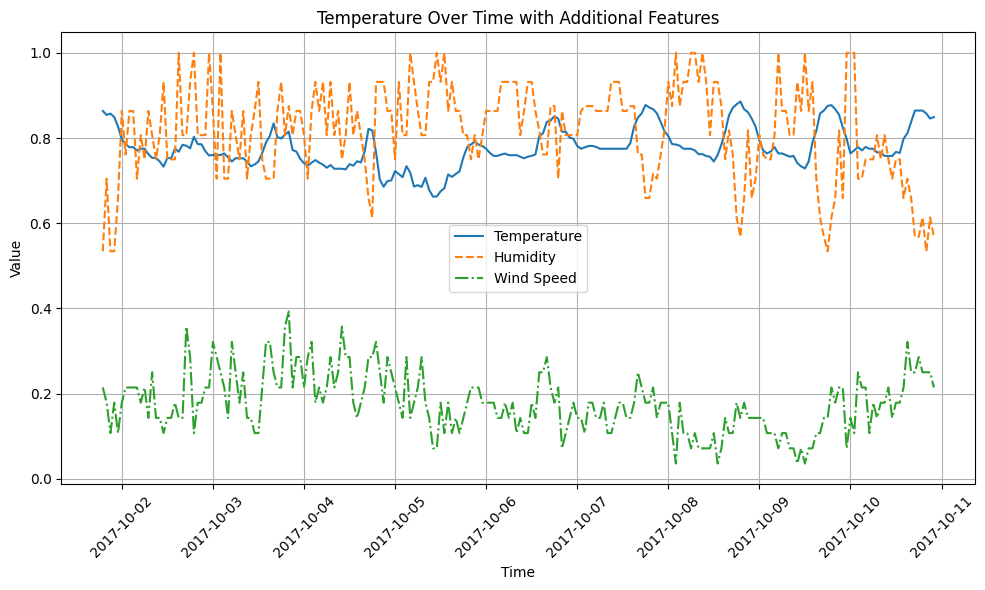

In [6]:
#visualising data within the dataframe with scaled values
miami_k_visual = miami_k_scaled.copy()
columns_to_scale = ['humidity', 'pressure', 'wind_speed', 'temperature']
min_max_scaler = MinMaxScaler()
miami_k_visual[columns_to_scale] = min_max_scaler.fit_transform(miami_k_visual[columns_to_scale])

start_time = pd.to_datetime('2017-10-01 19:00:00')
end_time = pd.to_datetime('2017-10-10 22:00:00')

filtered_df = miami_k_visual[(miami_k_visual.index >= start_time) & (miami_k_visual.index <= end_time)]

# Plot temperature over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['temperature'], label='Temperature', linestyle='-')

# Additional features
plt.plot(filtered_df.index, filtered_df['humidity'], label='Humidity', linestyle='--')
plt.plot(filtered_df.index, filtered_df['wind_speed'], label='Wind Speed', linestyle='-.')

# Customize the plot
plt.title('Temperature Over Time with Additional Features')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


### NOAA 2022 - present daily weather data 
The csv downloaded included all the weather stations in Florida and its data. For simplicity, I choose the data from the Miami International Airport, as it seemed like a good representation of Miami weather.

In [7]:
file_path = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/miami_noaa_2223.csv'
noaa = pd.read_csv(file_path)

#filter to data of one station
miami_noaa = noaa[noaa['STATION'] == "USW00012839"]
miami_noaa = miami_noaa.drop(columns=['STATION', 'PGTM', 'TOBS', 'WDMV'])

#counting number of missing values
missing_values_count = miami_noaa.isna().sum()
print("Count of missing values in each column:")
print(missing_values_count)

miami_noaa = miami_noaa.dropna()
miami_noaa['DATE'] = pd.to_datetime(miami_noaa['DATE'])
miami_noaa.set_index('DATE', inplace=True)

miami_noaa.head()

Count of missing values in each column:
NAME    0
DATE    0
AWND    1
TAVG    0
TMAX    2
TMIN    1
WDF2    1
WDF5    3
WSF2    1
WSF5    3
dtype: int64


,NAME,AWND,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
DATE,,,,,,,,,
2022-01-01,"MIAMI INTERNATIONAL AIRPORT, FL US",7.61,76.0,82.0,70.0,130.0,150.0,17.0,30.0
2022-01-02,"MIAMI INTERNATIONAL AIRPORT, FL US",7.83,76.0,83.0,71.0,130.0,150.0,18.1,27.1
2022-01-03,"MIAMI INTERNATIONAL AIRPORT, FL US",6.71,73.0,81.0,64.0,210.0,300.0,15.0,21.0
2022-01-04,"MIAMI INTERNATIONAL AIRPORT, FL US",6.71,69.0,78.0,62.0,90.0,90.0,18.1,21.0
2022-01-05,"MIAMI INTERNATIONAL AIRPORT, FL US",5.82,73.0,81.0,67.0,240.0,240.0,14.1,17.0


In [8]:
#breaking down datetime into individual components
miami_noaa['year'] = miami_noaa.index.year
miami_noaa['month'] = miami_noaa.index.month
miami_noaa['day'] = miami_noaa.index.day

Here are the notations of the NOAA columns:

AWND = Average daily wind speed (meters per second)

WDF2 = Direction of fastest 2-minute wind (degrees)

WDF5 = Direction of fastest 5-second wind (degrees)

WSF2 = Fastest 2-minute wind speed (miles per hour)

WSF5 = Fastest 5-second wind speed (miles per hour) 

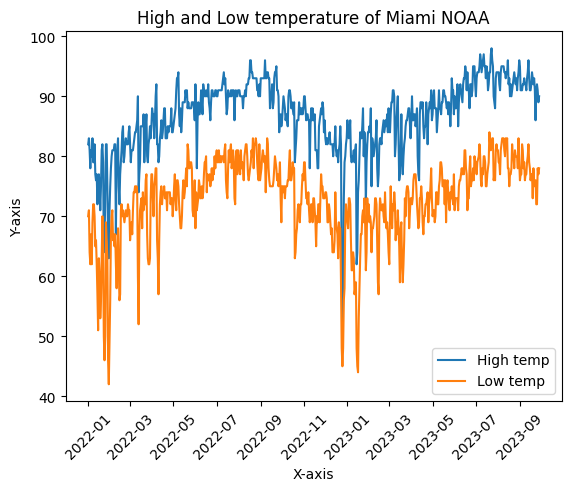

In [9]:
# Create a plot for maximum and minimum temperatures
plt.plot(miami_noaa.index, miami_noaa['TMAX'], label='High temp')
plt.plot(miami_noaa.index, miami_noaa['TMIN'], label='Low temp')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('High and Low temperature of Miami NOAA')
plt.legend()
plt.xticks(rotation=45)

# Display the graph
plt.show()

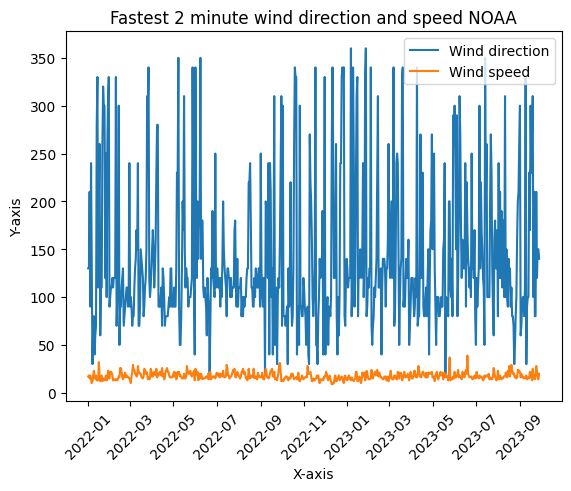

In [10]:
# Create a plot for maximum and minimum temperatures
plt.plot(miami_noaa.index, miami_noaa['WDF2'], label='Wind direction')
plt.plot(miami_noaa.index, miami_noaa['WSF2'], label='Wind speed')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Fastest 2 minute wind direction and speed NOAA')
plt.legend()
plt.xticks(rotation=45)

# Display the graph
plt.show()

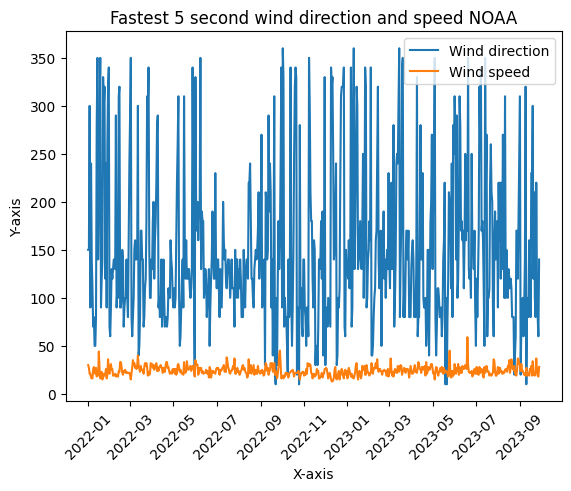

In [11]:
# Create a plot for maximum and minimum temperatures
plt.plot(miami_noaa.index, miami_noaa['WDF5'], label='Wind direction')
plt.plot(miami_noaa.index, miami_noaa['WSF5'], label='Wind speed')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Fastest 5 second wind direction and speed NOAA')
plt.legend()
plt.xticks(rotation=45)

# Display the graph
plt.show()

### Visual Crossing 2021 - 2022 historical weather data
Visual Crossing provides comprehensive historical data. I was only able to obtain the daily data as hourly data is only accecible with a subscription.

In [12]:
file_path = '/Users/stellasi/Desktop/Machine Learning/ysib_common_task/miami_vc_2021_2022.csv'
vc = pd.read_csv(file_path)

vc = vc.drop(columns=['name', 'stations','severerisk','preciptype'])

#counting number of missing values
missing_values_count = vc.isna().sum()
#print("\nCount of missing values in each column:")
#print(missing_values_count)

vc = vc.dropna()
#vc['datetime'] = pd.to_datetime(vc['datetime'])
#vc.set_index('datetime', inplace=True)

vc.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
0,2021-01-01,80.4,73.9,76.6,83.5,73.9,77.0,69.3,78.4,0.0,...,9.9,348.5,29.8,6,2021-01-01T07:07:42,2021-01-01T17:41:34,0.59,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
1,2021-01-02,80.5,70.7,76.1,82.7,70.7,76.2,67.2,74.8,0.0,...,9.9,384.0,32.7,5,2021-01-02T07:07:58,2021-01-02T17:42:15,0.63,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,2021-01-03,82.8,66.9,74.8,85.0,66.9,75.4,66.3,75.9,0.0,...,9.9,365.8,31.2,6,2021-01-03T07:08:12,2021-01-03T17:42:56,0.66,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,2021-01-04,74.3,63.8,69.6,74.3,63.8,69.6,56.0,64.7,0.0,...,9.9,309.0,26.7,3,2021-01-04T07:08:24,2021-01-04T17:43:38,0.70,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,2021-01-05,71.4,57.6,63.7,71.4,57.6,63.7,44.7,52.2,0.0,...,9.9,391.5,34.3,6,2021-01-05T07:08:36,2021-01-05T17:44:21,0.73,Clear,Clear conditions throughout the day.,clear-day


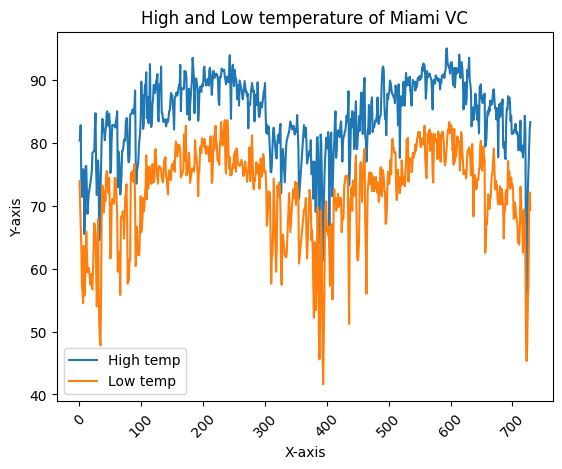

In [13]:
# Create a plot for maximum and minimum temperatures
plt.plot(vc.index, vc['tempmax'], label='High temp')
plt.plot(vc.index, vc['tempmin'], label='Low temp')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('High and Low temperature of Miami VC')
plt.legend()
plt.xticks(rotation=45)

# Display the graph
plt.show()

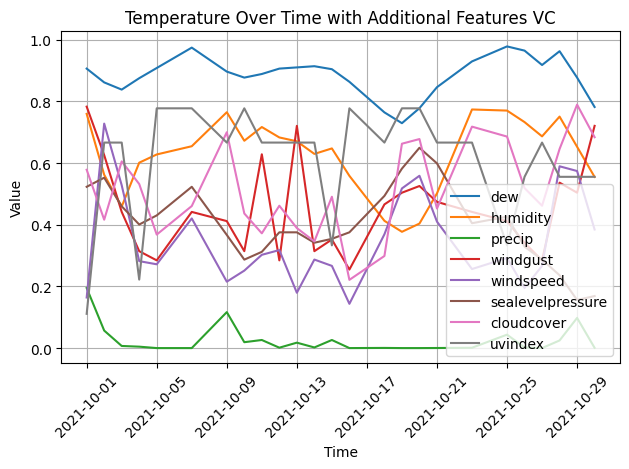

In [25]:
vc_visual = vc.copy()
vc_visual['datetime'] = pd.to_datetime(vc_visual['datetime'])
vc_visual.set_index('datetime', inplace=True)

#print(vc_visual.head())
columns_to_scale = ['dew','humidity','precip','windgust','windspeed',"sealevelpressure","cloudcover","uvindex"]
min_max_scaler = MinMaxScaler()
vc_visual[columns_to_scale] = min_max_scaler.fit_transform(vc_visual[columns_to_scale])

start_time = pd.to_datetime('2021-10-01')
end_time = pd.to_datetime('2021-10-30')

filtered_df = vc_visual[(vc_visual.index >= start_time) & (vc_visual.index <= end_time)]

for i in range(len(columns_to_scale)):
    plt.plot(filtered_df.index, filtered_df[columns_to_scale[i]], label=columns_to_scale[i], linestyle='-')

# Customize the plot
plt.title('Temperature Over Time with Additional Features VC')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

To help with further test my predictions, I decided to use forcast data with weather features from different websites as an additional measure of performance to see how I well my models did in comparison to professional websites.

### Tomorrow.io API 5-day weather forcasting
The Tomorrow.io is a powerful API tool that provides a free 5-day weather forcast with comprehensive weather features. I will be using this dataset to help me predict future temprature.

In [16]:
url = ("https://api.tomorrow.io/v4/weather/forecast"
       "?location=miami&timesteps=1h&units=imperial&apikey=Q8FIcxNzlQR8DUrYpX8uIqfSACDC894b")

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

json_string = response.text
data = json.loads(json_string)

miami_forcast = pd.json_normalize(data['timelines']['hourly'])
miami_forcast.to_csv('miami_5_day_forcast.csv', index=False)
miami_forcast.head()

,time,values.cloudBase,values.cloudCeiling,values.cloudCover,values.dewPoint,values.evapotranspiration,values.freezingRainIntensity,values.humidity,values.iceAccumulation,values.iceAccumulationLwe,...,values.snowIntensity,values.temperature,values.temperatureApparent,values.uvHealthConcern,values.uvIndex,values.visibility,values.weatherCode,values.windDirection,values.windGust,values.windSpeed
0,2023-11-11T18:00:00Z,NaN,NaN,6.00,74.64,0.020,0,78.00,0,0.0,...,0,82.18,88.70,2.0,6.0,9.94,1000,130.50,15.24,8.53
1,2023-11-11T19:00:00Z,NaN,NaN,6.03,70.62,0.018,0,61.78,0,0.0,...,0,85.66,91.07,1.0,4.0,9.94,1000,105.23,9.48,8.29
2,2023-11-11T20:00:00Z,NaN,NaN,1.03,69.79,0.015,0,62.78,0,0.0,...,0,84.30,88.84,1.0,2.0,9.94,1000,97.02,11.47,9.29
3,2023-11-11T21:00:00Z,NaN,NaN,1.92,70.62,0.010,0,65.90,0,0.0,...,0,83.57,88.38,0.0,0.0,9.94,1000,86.34,12.51,9.05
4,2023-11-11T22:00:00Z,NaN,NaN,3.84,70.61,0.006,0,69.26,0,0.0,...,0,81.94,86.16,0.0,0.0,9.94,1000,86.21,11.95,8.82


### Visual Crossing 6-day daily weather forcast

The Visual Crossing platform also provides weather forcast data through its API. The purpose of this data is to be able to match up the features of the datasets to measure the accuracy of my prediction tool.

In [17]:
url = ("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/miami/2023-10-17/2023-10-23?unitGroup=us&include=days&key=D7ALG73WYJ7SRD7CCMYA6KJSA&contentType=json")

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

json_string = response.text
data = json.loads(json_string)

vc_forcast = pd.json_normalize(data['days'])
vc_forcast.to_csv('vc_forcast.csv', index=False)

vc_forcast.head()

,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunrise,sunriseEpoch,sunset,sunsetEpoch,moonphase,conditions,description,icon,stations,source
0,2023-10-17,1697515200,75.5,62.8,69.3,75.5,62.8,69.3,51.2,53.3,...,07:20:27,1697541627,18:51:33,1697583093,0.10,Clear,Clear conditions throughout the day.,clear-day,"[0878W, KHWO, 72202412882, 72203792809, 0235W,...",obs
1,2023-10-18,1697601600,82.6,64.3,73.3,83.3,64.3,73.4,58.0,59.5,...,07:20:58,1697628058,18:50:38,1697669438,0.14,Clear,Clear conditions throughout the day.,clear-day,"[0878W, KHWO, 72202412882, 72203792809, 0235W,...",obs
2,2023-10-19,1697688000,85.2,70.2,77.6,86.0,70.2,77.9,63.1,62.3,...,07:21:30,1697714490,18:49:43,1697755783,0.17,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"[0878W, KHWO, 0235W, 72202412882, 72203792809,...",obs
3,2023-10-20,1697774400,83.8,75.8,78.3,87.5,75.8,79.2,67.3,69.1,...,07:22:02,1697800922,18:48:50,1697842130,0.21,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"[0878W, KHWO, 0235W, 72202412882, 72203792809,...",obs
4,2023-10-21,1697860800,87.0,67.9,77.8,89.6,67.9,78.6,66.0,68.4,...,07:22:35,1697887355,18:47:57,1697928477,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"[0878W, KHWO, 72202412882, 72203792809, 0235W,...",obs


In [26]:
#matching up columns with the previous visual crossing dataset to make a full historical + forcast vc dataframe
vc_forcast.rename( {"pressure": "sealevelpressure"}, axis=1, inplace=True)

#deleting unmatched columns with previous dataset
columns_to_remove = ['sunriseEpoch', 'sunsetEpoch', 'stations','datetimeEpoch','severerisk','preciptype',"source"]
vc_forcast.drop(columns = columns_to_remove, inplace=True)

In [27]:
#combining forcast data with historical data
vc_combined = pd.concat([vc, vc_forcast], axis=0)

vc_combined = vc_combined.reset_index(drop=True)
vc_combined.drop(columns = "datetime", inplace = True)
vc_combined.tail(15)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
668,58.1,47.9,51.0,58.1,42.2,49.7,34.1,52.6,0.000,0.0,...,9.9,83.3,7.1,4.0,2022-12-24T07:04:39,2022-12-24T17:36:22,0.04,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
669,49.2,45.3,47.8,46.7,39.8,43.3,33.5,57.6,0.038,100.0,...,9.9,24.5,2.1,2.0,2022-12-25T07:05:05,2022-12-25T17:36:55,0.08,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain
670,55.7,48.2,52.0,55.7,43.7,50.6,44.2,76.3,0.312,100.0,...,9.5,22.3,1.9,1.0,2022-12-26T07:05:31,2022-12-26T17:37:30,0.11,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain
671,72.7,55.3,61.9,72.7,55.3,61.9,57.5,86.5,0.179,100.0,...,9.1,54.6,4.7,2.0,2022-12-27T07:05:54,2022-12-27T17:38:05,0.15,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain
672,76.0,57.5,67.5,76.0,57.5,67.5,57.5,71.9,0.000,0.0,...,9.9,121.6,10.7,6.0,2022-12-28T07:06:17,2022-12-28T17:38:42,0.18,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
673,79.2,69.5,74.1,79.2,69.5,74.1,65.0,73.3,0.000,0.0,...,9.9,82.2,7.2,4.0,2022-12-29T07:06:39,2022-12-29T17:39:19,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
674,82.3,72.1,76.1,86.2,72.1,77.0,70.0,82.0,0.000,0.0,...,9.3,107.7,9.4,6.0,2022-12-30T07:06:59,2022-12-30T17:39:57,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
675,83.3,69.3,75.6,88.0,69.3,76.8,69.9,83.4,0.000,0.0,...,9.3,97.1,8.2,4.0,2022-12-31T07:07:18,2022-12-31T17:40:36,0.28,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
676,75.5,62.8,69.3,75.5,62.8,69.3,51.2,53.3,0.000,0.0,...,9.8,182.3,15.8,8.0,07:20:27,18:51:33,0.10,Clear,Clear conditions throughout the day.,clear-day
677,82.6,64.3,73.3,83.3,64.3,73.4,58.0,59.5,0.000,0.0,...,9.9,177.8,15.2,7.0,07:20:58,18:50:38,0.14,Clear,Clear conditions throughout the day.,clear-day


## Modeling and Prediction of Highest Temperature in Miami
Below, I used the linear regression model, the random forest model, and the long-short term memeory model to predict the highest temperature in Miami, and evaluate the prediction validity of the models.

### Linear Regression Model
I am using the NOAA data for this model, which has daily weather temperature since 2022. In addition, I am using the fastest 2 minute wind direction (WDF2) and speed (WSF2) as weather features. My main rationale for using these two data columns as features is because they come in a pair versus average wind speed, which offers better coverage. Conversly, fastest 5 second wind direction would be too volatile to offer a stable and accurate prediction.

In [34]:
data_x = miami_noaa[['day','year', 'month','WDF2', 'WSF2']].copy()
y = miami_noaa[["TMAX", "TMIN"]]

# Create feature matrix (X) and target vector (y)
X, y = data_x, y

# Split the data into training and testing sets
X_train_noaa, X_test_noaa, y_train_noaa, y_test_noaa = train_test_split(data_x, y, test_size=0.2, random_state=42)

print(X_train_noaa.head())
print(X_test_noaa)
print(y_train_noaa)
print(y_test_noaa)


            day  year  month   WDF2  WSF2
DATE                                     
2022-01-07    7  2022      1   30.0  12.1
2022-04-15   15  2022      4   70.0  25.9
2022-04-25   25  2022      4  100.0  18.1
2023-05-12   12  2023      5   90.0  21.9
2023-07-25   25  2023      7   90.0  17.0
            day  year  month   WDF2  WSF2
DATE                                     
2022-11-26   26  2022     11  130.0  14.1
2022-09-05    5  2022      9  120.0  14.1
2023-01-26   26  2023      1  330.0  13.0
2022-05-26   26  2022      5  110.0  18.1
2023-05-15   15  2023      5   90.0  19.9
...         ...   ...    ...    ...   ...
2022-10-30   30  2022     10   80.0  16.1
2022-08-10   10  2022      8  100.0  19.9
2022-07-12   12  2022      7  130.0  16.1
2023-08-11   11  2023      8  310.0  17.0
2022-12-19   19  2022     12  100.0  16.1

[127 rows x 5 columns]
            TMAX  TMIN
DATE                  
2022-01-07  83.0  69.0
2022-04-15  83.0  72.0
2022-04-25  85.0  74.0
2023-05-12  88.0  79.

In [35]:
#Sort the testing and training data by sequential order
testing_data = pd.concat([X_test_noaa, y_test_noaa], axis=1)
testing_data.sort_index(inplace=True)

# Separate the sorted DataFrame back into features and labels
y_test_sorted = testing_data[['TMAX', 'TMIN']]
X_test_sorted = testing_data.drop(columns=['TMAX', 'TMIN'])  
X_test_sorted

,day,year,month,WDF2,WSF2
DATE,,,,,
2022-01-03,3,2022,1,210.0,15.0
2022-01-11,11,2022,1,60.0,15.0
2022-01-25,25,2022,1,120.0,14.1
2022-01-30,30,2022,1,330.0,16.1
2022-01-31,31,2022,1,90.0,15.0
...,...,...,...,...,...
2023-08-27,27,2023,8,100.0,15.0
2023-08-29,29,2023,8,200.0,23.9
2023-09-16,16,2023,9,300.0,17.0


MAE: 4.45
MSE: 34.53
RMSE: 5.88


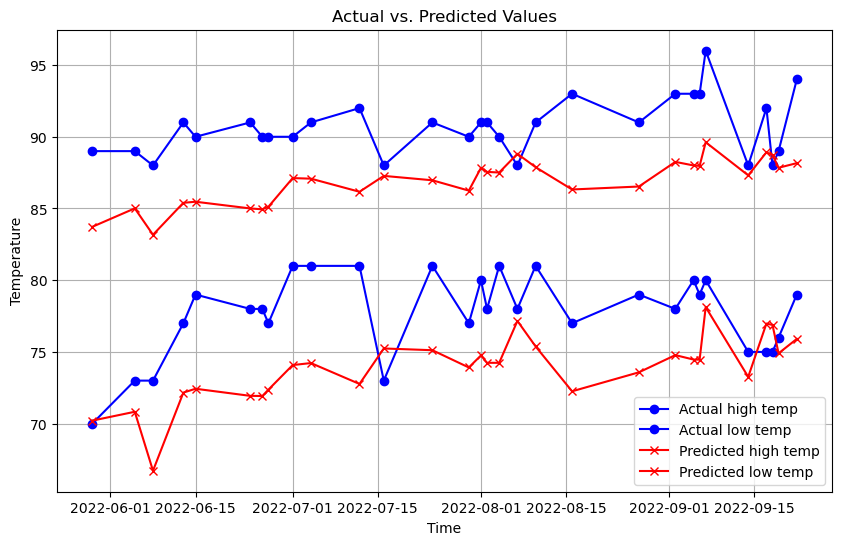

In [43]:
model = LinearRegression()
model.fit(X_train_noaa, y_train_noaa)

# Make predictions on the testing data
y_pred = model.predict(X_test_sorted)

# Evaluate the model
mae = mean_absolute_error(y_test_sorted, y_pred)
mse = mean_squared_error(y_test_sorted, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

# Define the start and end indices for the time window you want to visualize
start_index = 30  # Modify this to your desired start index
end_index = 60  # Modify this to your desired end index

# Make predictions for the specified time window
y_pred_window = y_pred[start_index:end_index]
y_test_window = y_test_sorted[start_index:end_index]

# Create a line plot for the specified time window
plt.figure(figsize=(10, 6))
plt.plot(y_test_window.index, y_test_window["TMAX"], label="Actual high temp", marker='o', color='b')
plt.plot(y_test_window.index, y_test_window["TMIN"], label="Actual low temp", marker='o', color='b')
plt.plot(y_test_window.index, y_pred_window[:, 0], label="Predicted high temp", marker='x', color='r')
plt.plot(y_test_window.index, y_pred_window[:, 1], label="Predicted low temp", marker='x', color='r')

plt.title("Actual vs. Predicted Values")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()


#### comment on the linear regression model

From the prediction vs actual graph, we can see that the lines are fairly off from each other. Additionally, the MSE value of 34.53 indicates that the model is not the best for predicting temperature likely due to the simplicity of the model. Additionally, the dataset that I selected for this model was not the best as there was a lack of features to predict temperature on. I only used date and fastest 2 minute wind direction and speed to predict the highest temperature. Additionally, daily data does not allow for a comprehensive window in the shifting trends of weather.

Next, I took the forcast data from Tomorrow.io and used matching features to predict the highest temperature of the next few days. I then compared what my model predicted and the forcast data to see how my model did.

In [58]:
##Using forcast data to predict tomorrow's highest temp
df = miami_forcast[['time','values.windDirection', 'values.windSpeed']]
df = df.rename(columns={'values.windDirection': 'WDF2', 'values.windSpeed': 'WSF2'})

# Convert the 'date' column to a Pandas DateTime object
df['time'] = pd.to_datetime(df['time'])

# Extract relevant date features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

df.drop(columns=['time'], inplace=True)

result = df.groupby('day')[['year','month','WDF2', 'WSF2']].max().reset_index()
result_df = pd.DataFrame(result)

# Tomorrow.io gives wind speed in meter/second so I am converting it to miles per hour to be the same as NOAA
result_df["WSF2"] = result_df["WSF2"] * 2.23694

# Print the result
print(result_df)

forcast = miami_forcast[['time','values.temperature']]
forcast = forcast.rename(columns={'values.temperature': 'temperature'})

forcast['time'] = pd.to_datetime(forcast['time'])

# Extract relevant date features
forcast['day'] = forcast['time'].dt.day

forcast.drop(columns=['time'], inplace=True)

forcast_temp = forcast.groupby('day')['temperature'].agg(TMAX='max', TMIN='min').reset_index()
forcast_temp = pd.DataFrame(forcast_temp)
forcast_temp

   day  year  month    WDF2       WSF2
0   17  2023     10  351.58  14.786173
1   18  2023     10  355.34  23.197068
2   19  2023     10  354.19  19.662703
3   20  2023     10  336.67  20.356154
4   21  2023     10  305.79  31.071097
5   22  2023     10  352.19  25.210314


,day,TMAX,TMIN
0,17,75.28,71.43
1,18,80.15,58.31
2,19,82.76,65.99
3,20,85.21,66.96
4,21,87.09,74.34
5,22,83.75,74.72


[[90.17614231 73.10430405]
 [91.16568925 75.1593897 ]
 [90.70210372 74.2776277 ]
 [90.92515886 74.83204317]
 [92.53366925 78.23329088]
 [91.32544868 75.71681519]]


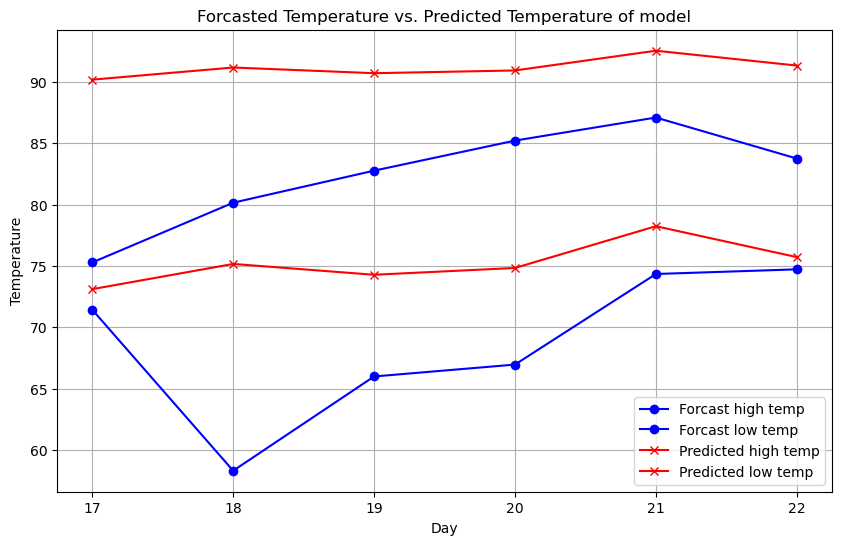

In [59]:
#plotting the predicted temperature value of the data and the forcasted data from Tomorrow.io
y_pred = model.predict(result_df)
print(y_pred)

days = result_df["day"]

plt.figure(figsize=(10, 6))
plt.plot(days, forcast_temp[["TMAX"]], label="Forcast high temp", marker='o', color='b')
plt.plot(days, forcast_temp[["TMIN"]], label="Forcast low temp", marker='o', color='b')
plt.plot(days, y_pred[:, 0], label="Predicted high temp", marker='x', color='r')
plt.plot(days, y_pred[:, 1], label="Predicted low temp", marker='x', color='r')

plt.title("Forcasted Temperature vs. Predicted Temperature of model")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

To trade, I would take the value of the first column of the prediction. For example, for October 17th, I would predict from my model that the high temperature would be 90 degrees in Miami. However, the weather API forcasts 75 degrees as the high temp, which is very different from what I predicted. 

A potential explanation for the big prediction difference is because the feature data for my predictions come from another data source. I was unable to locate current fastest 2-minute wind speed and direction data from NOAA. Instead, I used wind speed data from tomorrow.io, which is slightly different from fastest 2-minute wind speed. This likely exacerbated the issue.

#### Conclusion on my linear regression model
The graph shows that my predictions are fairly off compared to the weather forcasted values. That is expected as I am only using a simple linear regression model, which oversimplifies the problem.

What I would do differently next time:
    
    1. Use minimum temperature as another feature as I am only interested in the high temperature.
    
    2. Disregarded the date as a predicting value as it doesn't seem to have too big of an effect.
    
    3. Find datasets with more features to better capture the higest temperature.
    
    4. Make sure to use data features that are easily accessible or use data sources that offer historical and 
    forcast data with the same features and unit for more accurate prediction.

###  Random Forest model
For this data, I am using hourly weather data from 2012 until 2017. The features that I am using to predict temperature includes humidity, pressure, wind speed, and date. Since I am using hourly data, I am interested in using the large amount of data to predict temperature instead of high temperature with weather features. To get the high temperature, I will simply predict the temperature for hours of the day and manually select the highest temperature.

In [64]:
miami_k_scaled.reset_index(inplace=True, drop=True)
miami_k_scaled.drop(columns = ["weather_descript", "wind_direction"], inplace=True)
miami_k_scaled.head()

,humidity,pressure,wind_speed,temperature,year,month,day,hour
0,83.0,1011.0,3.0,79.826000,2012,10,1,13
1,82.0,1011.0,3.0,79.848532,2012,10,1,14
2,82.0,1011.0,3.0,79.909843,2012,10,1,15
3,82.0,1011.0,3.0,79.971154,2012,10,1,16
4,81.0,1011.0,3.0,80.032465,2012,10,1,17


In [65]:
X = miami_k_scaled.drop(columns = ["temperature"])
y = miami_k_scaled["temperature"]

# Split the dataset into training and testing sets
train_index = int(X.shape[0]*0.8)

X_train_k = X.iloc[:train_index]
Y_train_k = y.iloc[:train_index]

X_test_k = X.iloc[train_index:]
Y_test_k = y.iloc[train_index:]

X_train_k.head()

,humidity,pressure,wind_speed,year,month,day,hour
0,83.0,1011.0,3.0,2012,10,1,13
1,82.0,1011.0,3.0,2012,10,1,14
2,82.0,1011.0,3.0,2012,10,1,15
3,82.0,1011.0,3.0,2012,10,1,16
4,81.0,1011.0,3.0,2012,10,1,17


In [66]:
# Create a Random Forest classifier
# You can specify hyperparameters like the number of trees, max depth, etc.
rf_model = RandomForestRegressor(n_estimators=30, random_state=42)

# Train the model on the training data
rf_model.fit(X_train_k, Y_train_k)

# Make predictions on the test data
Y_pred = rf_model.predict(X_test_k)

mse = mean_squared_error(Y_test_k, Y_pred)
print(f"Mean Squared Error: {mse}")

# You can also access feature importances
feature_importances = rf_model.feature_importances_
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

Mean Squared Error: 20.891187438262747
Feature Importances:
Feature 0: 0.10485483001653224
Feature 1: 0.07300835855456887
Feature 2: 0.029237143323521387
Feature 3: 0.055648934324835385
Feature 4: 0.42778349356508905
Feature 5: 0.10554522221866189
Feature 6: 0.20392201799679105


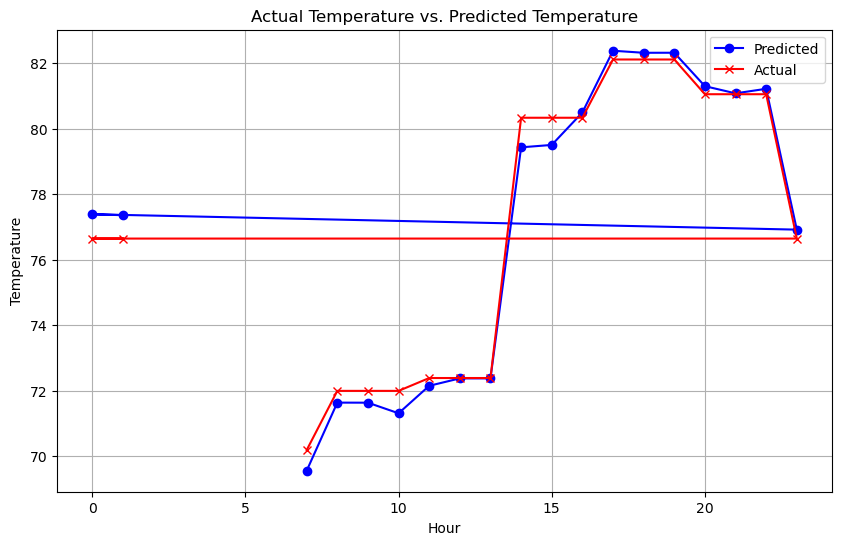

In [74]:
start_index = 5 
end_index = 24

Y_pred_window = Y_pred[start_index:end_index]
Y_test_window = Y_test_k[start_index:end_index]

plt.figure(figsize=(10, 6))
hour = X_test_k["hour"][start_index:end_index]
plt.plot(hour, Y_pred_window, label="Predicted", marker='o', color='b')
plt.plot(hour, Y_test_window, label="Actual", marker='x', color='r')

plt.title("Actual Temperature vs. Predicted Temperature")
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

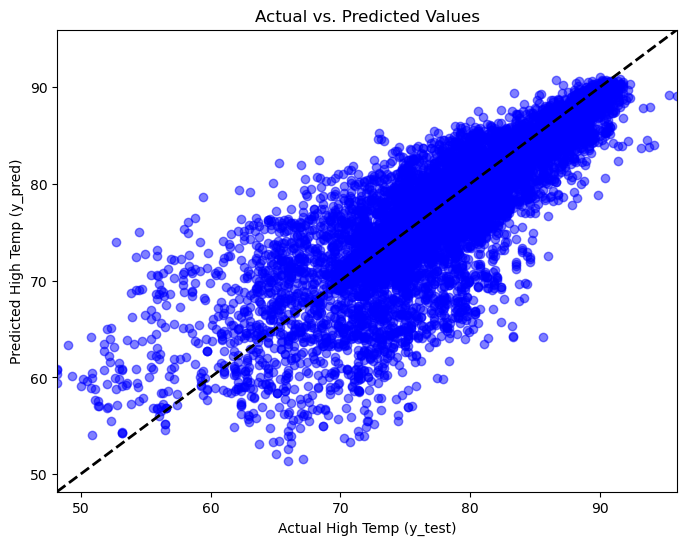

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_k, Y_pred, c='b', marker='o', alpha=0.5)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual High Temp (y_test)")
plt.ylabel("Predicted High Temp (y_pred)")

# Add a diagonal line for comparison
plt.plot([min(Y_test_k), max(Y_test_k)], [min(Y_test_k), max(Y_test_k)], 'k--', lw=2)
plt.xlim([min(Y_test_k), max(Y_test_k)])
plt.ylim([min(Y_test_k), max(Y_test_k)])

plt.show()

#### comment on the random forest model
The actual vs. predicted temperature graph is in a circular pattern because the data is hourly and thus will circle around once it goes past 24hrs. The comparitive graph shows that the predictions are fairly accurate, and the second graph shows that the model is pretty good and predicting hourly temperature. The mean stardard error value of 20.89 is the better than the linear regression model.

We will now predict the weather for future days using forcast data from wunderground and use their forcast data as an additional measure of accuracy. I made the assumption that the highest temperature of the day would fall between 12pm and 4pm, so I am choosing these five hour points to predict temperature. I will take the maximum value as the high temperature of the day.

In [84]:
feature_names = ['humidity', 'pressure', 'wind_speed', 'year', 'month', 'day', 'hour']

# Weather data for each hour.
twelvepm = [52, 1017.95, 4.91744, 2023, 10, 18, 12]
onepm = [52, 1017.27, 5.36448, 2023, 10, 18, 1]
twopm = [51, 1016.59, 5.81152, 2023, 10, 18, 2]
threepm = [51, 1015.92, 5.36448, 2023, 10, 18, 3]
fourpm = [51, 1015.58, 5.36448, 2023, 10, 18, 4]

# Forecast for each hour.
forecast_temp = [77, 79, 80, 81, 81]

# Create structured arrays.
weather_data = np.array([twelvepm, onepm, twopm, threepm, fourpm])
weather_data = pd.DataFrame(weather_data)

# Set the column names to the feature names
weather_data.columns = feature_names
print(weather_data)

   humidity  pressure  wind_speed    year  month   day  hour
0      52.0   1017.95     4.91744  2023.0   10.0  18.0  12.0
1      52.0   1017.27     5.36448  2023.0   10.0  18.0   1.0
2      51.0   1016.59     5.81152  2023.0   10.0  18.0   2.0
3      51.0   1015.92     5.36448  2023.0   10.0  18.0   3.0
4      51.0   1015.58     5.36448  2023.0   10.0  18.0   4.0


[74.24082483 75.1406     74.11418    74.0564     73.60414071]


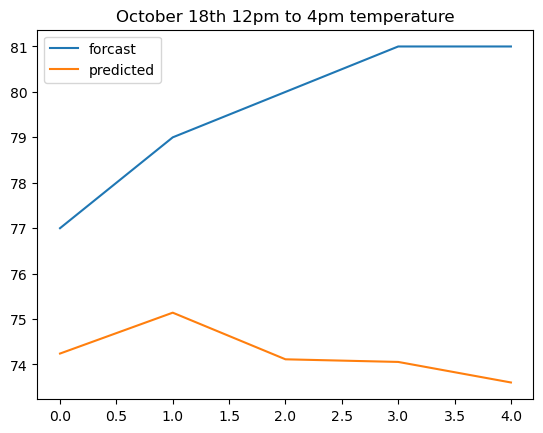

In [87]:
predict = rf_model.predict(weather_data)
print(predict)
plt.plot(range(5), forecast_temp, label='forcast')
plt.plot(range(5), predict, label='predicted')
plt.legend()
plt.title("October 18th 12pm to 4pm temperature")
plt.show()

Out of the five predicted hourly temperature, I pick the highest number. In the case of October 18th, I would pick 75 degrees to be the highest temperature. The high temperature actually forcasted for October 18th is 81 degrees.

#### conclusion on the random forest model
My predicted values on future days and forcasted data from professional weather data is still fairly far apart. The gap does seem to get smaller, and the model also has a smaller mean standard error value. The drawback of my model is most likely due to more dated data. Since my data was from 2012 - 2017, the trends found might be a bit off from current weather. In particular, according to my model output, month is a very significant feature in predicting weather. I wonder if I use more recent data if I will get a better prediction.

### Long Short-Term Memory (LSTM)
Learning from my previous models, I made the following improvements:

1) I used more features to predict high temperature

2) I used the low temperature as well to predict high temperature

3) I integrated historical weather data and forcast weather data to match in features to get the most uniform data to predict future high temperature.

In [28]:
#transform the categorical columns for both historical and forcast data from Visual Crossing
categorical_columns = [x for x in vc_combined.columns if vc[x].dtype == 'object']
#print(categorical_columns)
le = LabelEncoder()
vc_cat = vc_combined[categorical_columns]

vc_cat = vc_cat.apply(le.fit_transform)
vc_combined[categorical_columns] = vc_cat
vc_combined.tail(25)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
658,81.0,66.6,74.7,82.9,66.6,75.0,65.2,73.2,0.008,100.0,...,9.7,115.8,10.1,5.0,665,665,0.71,4,1,3
659,83.5,73.0,77.9,87.9,73.0,79.1,69.0,74.6,0.000,0.0,...,9.9,122.7,10.6,5.0,666,666,0.75,2,21,2
660,78.8,71.2,74.4,78.8,71.2,74.4,67.6,79.9,0.050,100.0,...,9.8,70.4,5.9,4.0,667,667,0.75,4,17,3
661,78.6,67.6,72.4,78.6,67.6,72.4,67.8,85.6,0.167,100.0,...,9.8,65.9,5.6,3.0,668,668,0.81,4,20,3
662,79.5,67.1,73.6,79.5,67.1,73.6,66.8,80.6,0.077,100.0,...,9.6,72.5,6.3,4.0,669,669,0.85,4,18,3
663,77.7,62.5,70.5,77.7,62.5,70.5,60.2,70.6,0.000,0.0,...,9.9,116.7,9.9,5.0,670,670,0.88,2,21,2
664,79.7,69.0,73.1,79.7,69.0,73.1,64.5,75.0,0.295,100.0,...,9.7,100.6,8.7,5.0,671,671,0.91,4,20,3
665,79.5,69.4,74.8,79.5,69.4,74.8,68.4,80.8,0.008,100.0,...,9.9,81.1,6.8,3.0,672,672,0.94,4,15,3
666,84.3,67.9,75.9,86.5,67.9,76.6,67.8,77.7,0.000,0.0,...,9.7,129.6,11.2,6.0,673,673,0.98,2,21,2
667,81.5,62.2,73.6,83.5,62.2,73.8,66.8,80.0,0.181,100.0,...,9.2,66.0,5.7,4.0,674,674,0.00,4,20,3


In [29]:
#remake the historical data dataframe
vc_hist = vc_combined.iloc[:-6]

In [30]:
#split data
x = vc_hist.drop(columns=['tempmax','sunrise','sunset'])
y = vc_hist["tempmax"]

#feature matrix (X) and target vector (y)
X, y = x, y

# Split the data into training and testing sets
train_index = int(x.shape[0]*0.8)

X_train = x.iloc[:train_index]
Y_train = y.iloc[:train_index]

X_test = x.iloc[train_index:]
Y_test = y.iloc[train_index:]

In [31]:
X_train.head()

,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,conditions,description,icon
0,73.9,76.6,83.5,73.9,77.0,69.3,78.4,0.0,0.0,0.0,...,1021.4,64.7,9.9,348.5,29.8,6.0,0.59,2,21,2
1,70.7,76.1,82.7,70.7,76.2,67.2,74.8,0.0,0.0,0.0,...,1020.4,64.2,9.9,384.0,32.7,5.0,0.63,2,21,2
2,66.9,74.8,85.0,66.9,75.4,66.3,75.9,0.0,0.0,0.0,...,1018.1,50.6,9.9,365.8,31.2,6.0,0.66,2,21,2
3,63.8,69.6,74.3,63.8,69.6,56.0,64.7,0.0,0.0,0.0,...,1016.9,88.8,9.9,309.0,26.7,3.0,0.70,2,21,2
4,57.6,63.7,71.4,57.6,63.7,44.7,52.2,0.0,0.0,0.0,...,1017.3,13.4,9.9,391.5,34.3,6.0,0.73,0,5,0


In [32]:
Y_train.head()

0    80.4
1    80.5
2    82.8
3    74.3
4    71.4
Name: tempmax, dtype: float64

In [35]:
model = Sequential()

# Add an LSTM layer with the number of units (neurons) you want
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a Dense output layer (you can customize the activation function)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=100)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) as a measure of model performance
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Epoch 1/100
17/17 [==============================] - 1s 9ms/step - loss: 324.5810
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 15.6311
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 10.9655
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 8.4436
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 6.6422
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 5.4014
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 4.4320
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 3.5309
Epoch 9/100
17/17 [==============================] - 0s 9ms/step - loss: 3.4867
Epoch 10/100
17/17 [==============================] - 0s 10ms/step - loss: 3.2761
Epoch 11/100
17/17 [==============================] - 0s 9ms/step - loss: 3.1127
Epoch 12/100
17/17 [==============================] - 0s 9ms/step - loss: 2.7692
Epoch 13/100
17/17 [=========

5/5 [==============================] - 0s 4ms/step


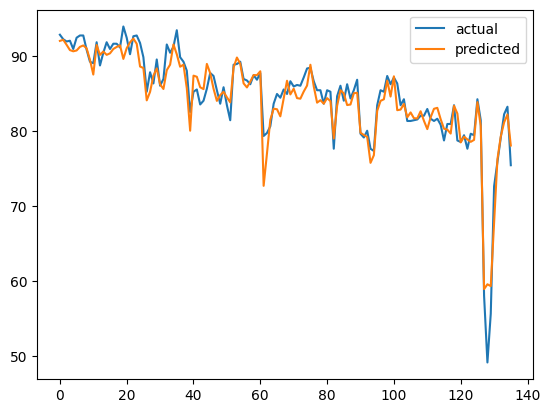

In [36]:
predictions = model.predict(X_test)
plt.plot(range(len(Y_test)), Y_test, label='actual')
plt.plot(range(len(Y_test)), predictions, label='predicted')
plt.legend()
plt.show()

#### Comment on the LSTM model
As shown by the graph and the MSE value of 3.974, the model is much more accurate with its predictions compared to previous models, indicading that LSTM is a much stronger model compared to both the linear regression model and the random forest when it comes to forcasting.

Now, I will use the forcast portion of my dataset to further test the strength of my model.

In [37]:
# Future forcast data
future = vc_combined.iloc[-6:]
f = future.drop(columns=['tempmax','sunset','sunrise'])
forcast = future['tempmax']
forcast

677    82.6
678    85.2
679    83.8
680    87.0
681    86.0
682    86.3
Name: tempmax, dtype: float64

1/1 [==============================] - 0s 23ms/step
[[81.83518 ]
 [82.62954 ]
 [82.25927 ]
 [86.981346]
 [86.51525 ]
 [84.67516 ]]


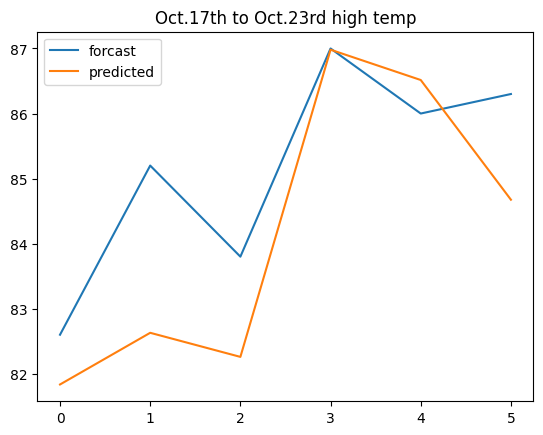

In [38]:
predictions = model.predict(f)
print(predictions)
plt.plot(range(6), forcast, label='forcast')
plt.plot(range(6), predictions, label='predicted')
plt.legend()
plt.title("Oct.17th to Oct.23rd high temp")
plt.show()

The goal is to predict next day and the day after's temperature. My prediction of high temperature for October 18th is 82 degrees, and the forcast data is 81.1 degrees. That is a very close prediction, which means my model does very well. The gap for October 19th as shown by the graph is fairly close as well. I am very happy with this model.

#### Conclusion on the LSTM model
My predictions for highest temperature is now getting very close to the forcasted weather of a professional website, signifying that this model is by far the best one. There is still some places where there is a 5 degree gap. However, for the purpose of Kalshi trading, we are only interested in the next two days, so I am happy with the accuracy level of my model.

One way that I can improve my model in the future would be to use more professional up to date hourly data to generate the best predictions. I think with more data points in hourly data, I would be more confident in consistent accuracy predictions. I was unable to get high quality hourly data without paying. So, this model is adequate for the goal at hand.

## Automating trade on Kalshi through its API

In [40]:
import kalshi_python
from KalshiClientsBaseV2 import ExchangeClient
import time
import uuid

In [41]:
demo_email = "ysib@bu.edu" # change these to be your personal credentials
demo_password = "Yansi0204%" # (for extra security, we recommend using a config file)

# for demo
demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"

In [42]:
exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

# first we will check on the exchange status to confirm you are properly connected...
print(exchange_client.get_exchange_status())

{'exchange_active': True, 'trading_active': True}


In [85]:
ticker = 'HIGHMIA-23OCT16-B80.5'

order_params = {'ticker':ticker,
                    'client_order_id':str(uuid.uuid4()),
                    'type':'limit',
                    'action':'buy',
                    'side':'yes',
                    'count':10,
                    'yes_price':70, # yes_price = 100 - no_price
                    'no_price':None, # no_price = 100 - yes_price
                    'expiration_ts':None,
                    'sell_position_floor':None,
                    'buy_max_cost':None}

exchange_client.create_order(**order_params)

{'ticker': 'HIGHMIA-23OCT16-B80.5', 'client_order_id': '242ec743-18f3-46b6-9530-155c75780222', 'side': 'yes', 'action': 'buy', 'count': 10, 'type': 'limit', 'yes_price': 70}


{'order': {'order_id': '4ac471a0-3fe5-44a8-8cf1-057d53709c82',
  'user_id': '9c413aac-e003-418d-995a-3fd29b548b3d',
  'ticker': 'HIGHMIA-23OCT16-B80.5',
  'status': 'executed',
  'yes_price': 70,
  'no_price': 30,
  'created_time': '2023-10-16T20:32:40.588133Z',
  'expiration_time': None,
  'action': 'buy',
  'side': 'yes',
  'type': 'limit',
  'client_order_id': '242ec743-18f3-46b6-9530-155c75780222',
  'order_group_id': ''}}

## Conclusion
This report focuses on using historical weather data and its weather features to predict highest temprature in Miami, and using that prediction to trade on Kalshi. I conclude that the LSTM is the best candidate in predicting future weather, and that the more weather features there are, the more accurate the model will be. If permitted, using hourly data would be good, but daily data is also adequate in predicting high temperature. Since Kalshi has been down, I have been unable to test whether my predictions can generate a profit. In that regards, it is inconclusive whether my models are valid for selecting the best contracts each day on Kalshi to purchase.